1. "https://www.strava.com/settings/api"
2. Create an application
    2a. "Authorization Callback Domain" needs to be "localhost" and "Website"
    should be "https://www.strava.testapp.com". Everything else can be whatever
    you want
3. 

In [ ]:
# <------ press the play button in the upper left corner when finished
CLIENT_ID = 'YOUR CLIENT ID'
CLIENT_SECRET = 'YOUR CLIENT SECRET'
REFRESH_TOKEN = 'YOUR REFRESH TOKEN'


CLIENT_ID = '92250'
# de9fe4848de472b31e678e456920aee3101993dc
REFRESH_TOKEN = '1a0dbcab4b5a442d4a022b900b2786500ef43c12'
CLIENT_SECRET = 'd9907c8a346944640c736f3a1c1ccda429a731df'
# REFRESH_TOKEN = '84211bfa5481f36a36ab3aeaf54b16ec43c6c083'

In [7]:
import pandas as pd
import numpy as np
import scipy as sp
from scipy import stats
from numpy.polynomial import polynomial
import requests
import urllib3
import matplotlib.pyplot as plt
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)


def calc_r_sq(coeffs, x, y, activity_df):
    x = list(activity_df[x])
    y = list(activity_df[y])

    expected_values = []
    for x_val in x:        
        expected_values.append(sum([coeffs[coeff_num] * x_val**coeff_num for coeff_num in range(len(coeffs))]))
    
    r = stats.pearsonr(x=expected_values, y=y)[0]
    r_sq = r**2

    return r_sq


def plot_best_fit(x, y, activity_df):
    y_vs_x_text = f"{y} vs {x}"
    print(f"\n{y_vs_x_text}")

    activity_df = activity_df.dropna(subset=[x, y])
    activity_df = activity_df.sort_values(by=x)
    activity_df.plot(x=x, y=y, kind='scatter', color='black', figsize=(20,10))

    poly_coeff = polynomial.polyfit(x=activity_df[x], y=activity_df[y], deg=2)
    poly_r_sq = calc_r_sq(poly_coeff, x, y, activity_df)
    poly_equation_text = "y = %.3gx^2 + %.3gx + %.3g   (r^2 = %.2g)" % (poly_coeff[2], poly_coeff[1], poly_coeff[0], poly_r_sq)

    linear_coeff = polynomial.polyfit(x=activity_df[x], y=activity_df[y], deg=1)
    linear_r_sq = calc_r_sq(linear_coeff, x, y, activity_df)
    linear_equation_text = "y = %.3gx + %.3g   (r^2 = %.2g)" % (linear_coeff[1], linear_coeff[0], linear_r_sq)

    print(poly_equation_text)
    print(linear_equation_text)

    plt.plot(activity_df[x], linear_coeff[1] * activity_df[x] + linear_coeff[0], color='green')
    plt.plot(activity_df[x], poly_coeff[2] * (activity_df[x]**2) + poly_coeff[1] * activity_df[x] + poly_coeff[0], color='blue')
    x_range = max(activity_df[x]) - min(activity_df[x])
    y_range = max(activity_df[y]) - min(activity_df[y])
    plt.text(max(activity_df[x]) - .25*x_range, max(activity_df[y]) + .125*y_range, poly_equation_text, size=14)
    plt.text(max(activity_df[x]) - .25*x_range, max(activity_df[y]) + .075*y_range, linear_equation_text, size=14)
    plt.savefig(f"{y_vs_x_text}.png")
    plt.show()


auth_url = "https://www.strava.com/oauth/token"
activites_url = "https://www.strava.com/api/v3/athlete/activities"

payload = {
    'client_id': CLIENT_ID,
    'client_secret': CLIENT_SECRET,
    'refresh_token': REFRESH_TOKEN,
    'grant_type': "refresh_token",
    'f': 'json'
}

print("Requesting Token...\n")
res = requests.post(auth_url, data=payload, verify=False)
print(res.json())
access_token = res.json()['access_token']
print("Access Token = {}\n".format(access_token))

df_columns = [
    'start_date_local',
    'name',
    'weighted_average_watts',
    'average_watts',
    'est_average_watts',
    'average_temp',
    'average_heartrate',
    'distance',
    'suffer_score'
]
activity_df = pd.DataFrame(columns=df_columns)

print("Loading Data (shouldn't take more than 30 seconds)...")
for page_num in range(1, 5):
    print(f"Loading page {page_num}...")
    header = {'Authorization': 'Bearer ' + access_token}
    param = {'per_page': 200, 'page': page_num}
    my_dataset = requests.get(activites_url, headers=header, params=param).json()
    for activity_num in range(200):
        if my_dataset[activity_num]['sport_type'] == 'Ride':
            activity = my_dataset[activity_num]
            new_row = {}
            for col_name in df_columns:
                try:
                    if col_name == 'average_watts' or col_name == 'est_average_watts':
                        if activity['device_watts']:
                            new_row['average_watts'] = activity['average_watts']
                            new_row['est_average_watts'] = np.nan
                        else:
                            new_row['average_watts'] = np.nan
                            new_row['est_average_watts'] = activity['average_watts']
                    else:
                        new_row[col_name] = activity[col_name]
                except Exception as error:
                    new_row[col_name] = np.nan
            activity_df.loc[len(activity_df.index)] = new_row


for col_name in df_columns:
    if col_name != 'start_date_local' and col_name != 'name':
        activity_df[col_name] = activity_df[col_name].astype(float)

activity_df['start_date_local'] = pd.to_datetime(activity_df['start_date_local'], infer_datetime_format=True)
# activity_df['date'] = activity_df['start_date_local'].dt.date
# activity_df['time'] = activity_df['start_date_local'].dt.time

activity_df = activity_df.loc[(activity_df['weighted_average_watts'] > activity_df['weighted_average_watts'].quantile(.01)) \
                            | (activity_df['est_average_watts'] > activity_df['est_average_watts'].quantile(.01))]

activity_df['watts_per_bpm'] = activity_df['average_watts'] / activity_df['average_heartrate']
activity_df['weighted_watts_per_bpm'] = activity_df['weighted_average_watts'] / activity_df['average_heartrate']
activity_df['w_per_bpm_per_distance'] = activity_df['average_watts'] / activity_df['average_heartrate'] / activity_df['distance']
print(activity_df)

Requesting Token...

{'token_type': 'Bearer', 'access_token': '84b601b91cd4ad8062469bd699475271cd2c72c9', 'expires_at': 1661040362, 'expires_in': 20181, 'refresh_token': '1a0dbcab4b5a442d4a022b900b2786500ef43c12'}
Access Token = 84b601b91cd4ad8062469bd699475271cd2c72c9

Loading Data (shouldn't take more than 15 seconds)...
Loading page 1...
Loading page 2...
Loading page 3...
Loading page 4...
       start_date_local                                          name  \
0   2022-08-12 18:49:25                                  Evening Ride   
1   2022-08-11 18:37:10  The cycling community around here is amazing   
2   2022-08-09 17:30:34                     Trying to get undunked on   
3   2022-08-07 17:28:12                          She likes McElroy ;)   
4   2022-08-06 08:16:17                               cool and breezy   
..                  ...                                           ...   
338 2020-12-29 10:10:37          Not a big fan of mountain biking tbh   
339 2020-12-28 16:1


weighted_average_watts vs average_temp
y = -0.0467x^2 + 0.86x + 262   (r^2 = 0.15)
y = -1.05x + 279   (r^2 = 0.14)


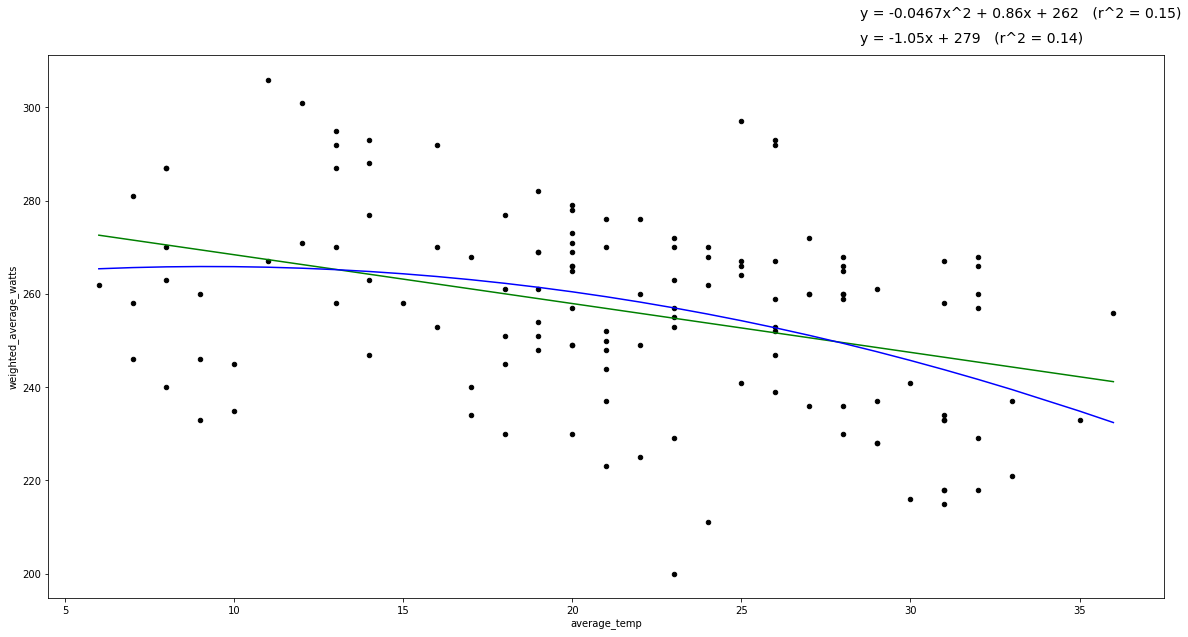


suffer_score vs average_temp
y = -0.265x^2 + 9.79x + 15.8   (r^2 = 0.085)
y = -1.07x + 113   (r^2 = 0.017)


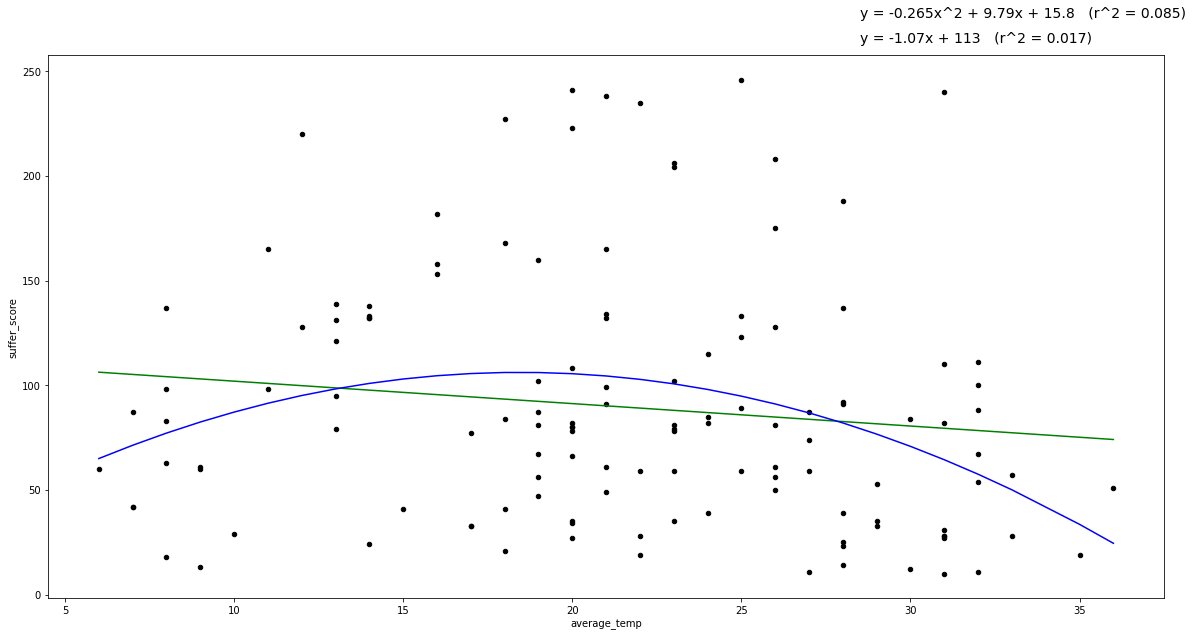


average_heartrate vs average_watts
y = 0.000331x^2 + 0.12x + 88   (r^2 = 0.53)
y = 0.272x + 70.7   (r^2 = 0.53)


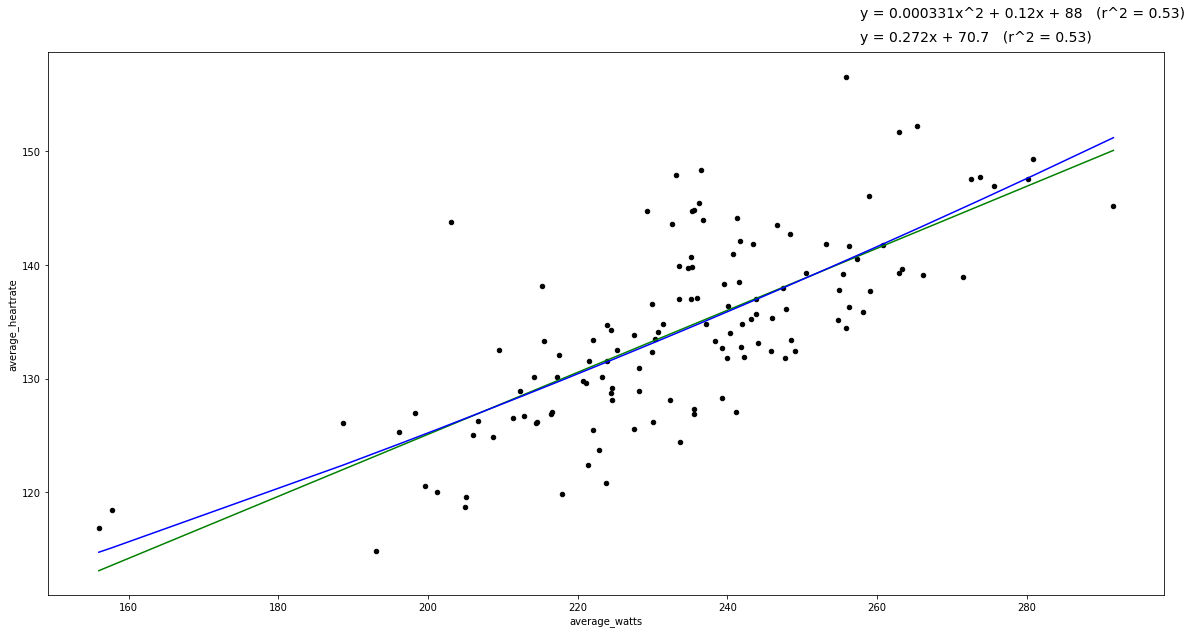


average_heartrate vs weighted_average_watts
y = 0.000265x^2 + 0.153x + 77.7   (r^2 = 0.53)
y = 0.287x + 60.7   (r^2 = 0.53)


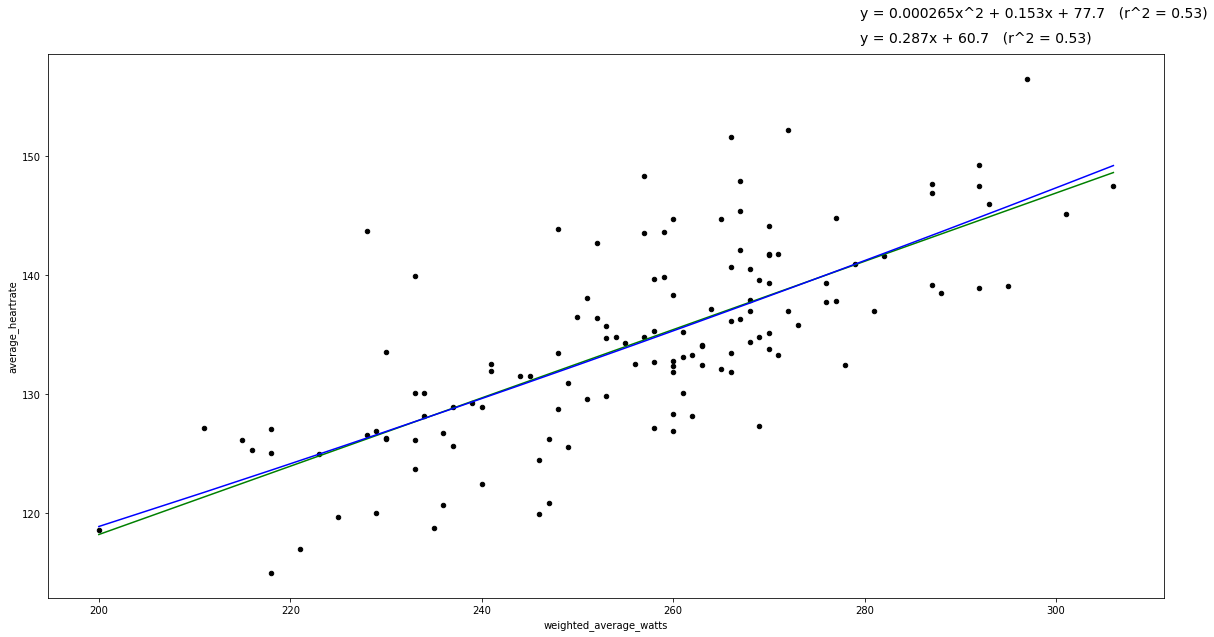


watts_per_bpm vs average_temp
y = -6.65e-05x^2 + -0.00517x + 1.89   (r^2 = 0.26)
y = -0.00789x + 1.91   (r^2 = 0.26)


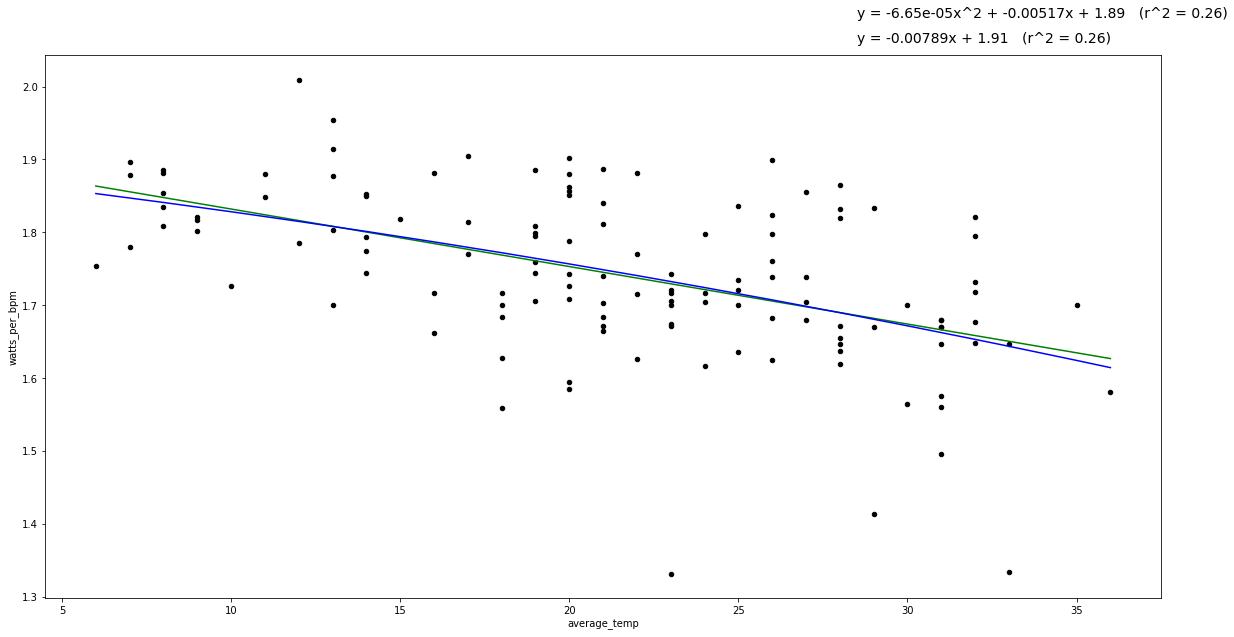


weighted_watts_per_bpm vs average_temp
y = 0.0001x^2 + -0.0112x + 2.1   (r^2 = 0.25)
y = -0.00712x + 2.06   (r^2 = 0.25)


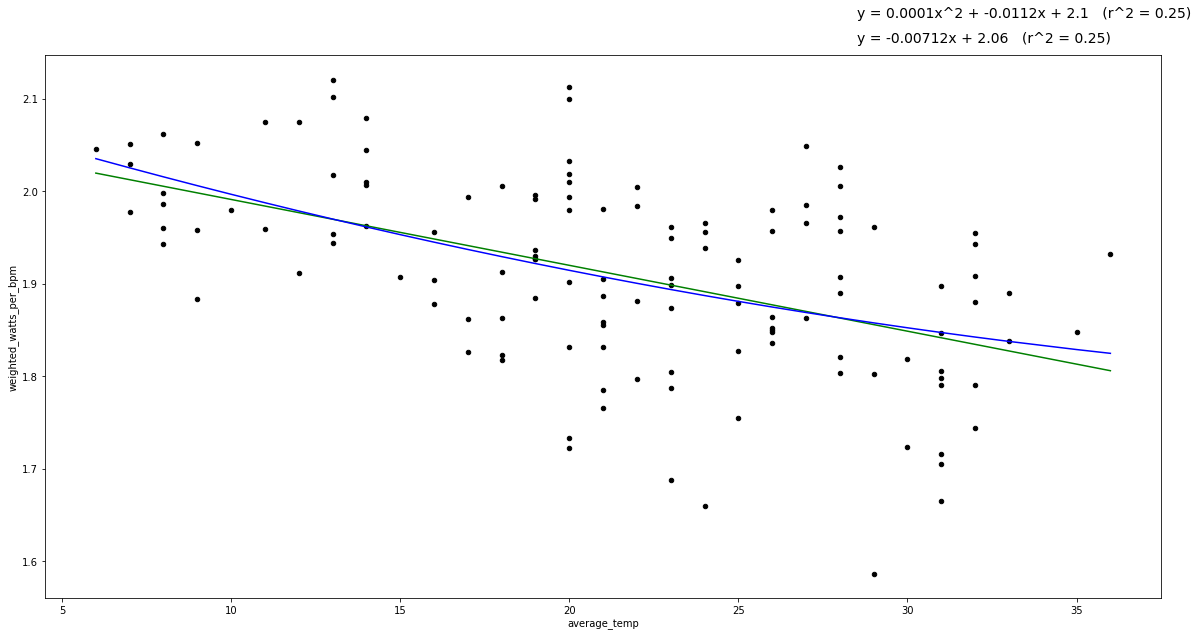


w_per_bpm_per_distance vs average_temp
y = 6.9e-08x^2 + -2.44e-06x + 5.76e-05   (r^2 = 0.046)
y = 3.88e-07x + 3.24e-05   (r^2 = 0.015)


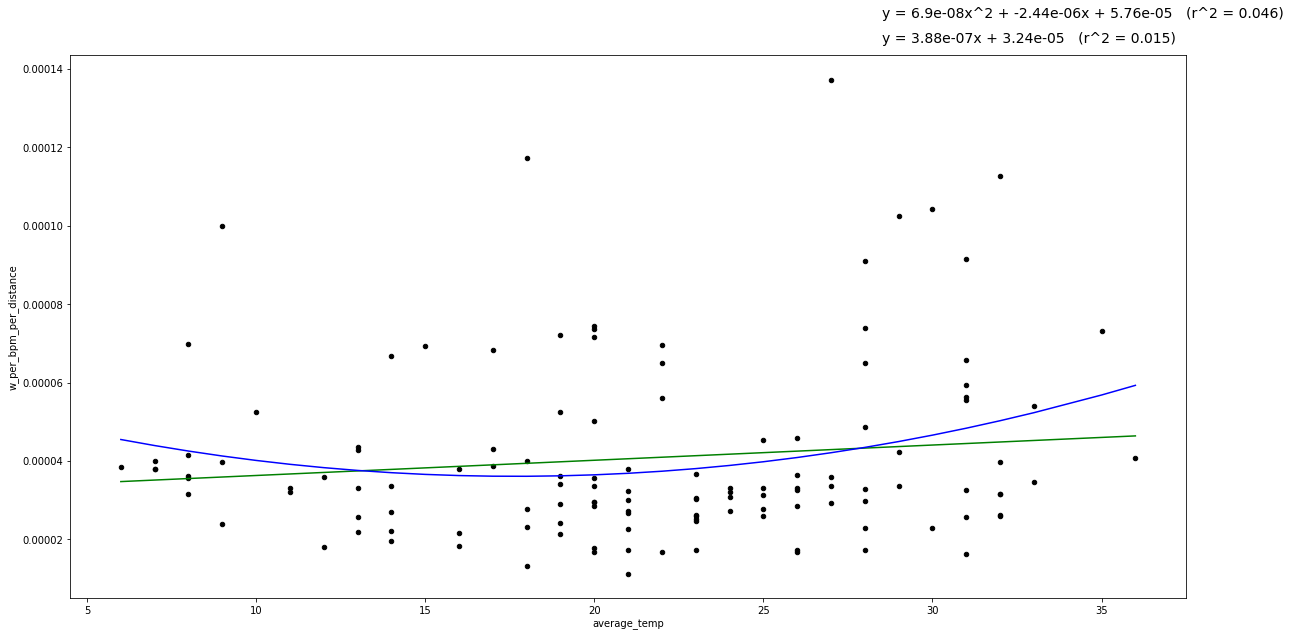


weighted_watts_per_bpm vs distance
y = -1.61e-11x^2 + 1.4e-06x + 1.89   (r^2 = 0.037)
y = -5.97e-07x + 1.94   (r^2 = 0.018)


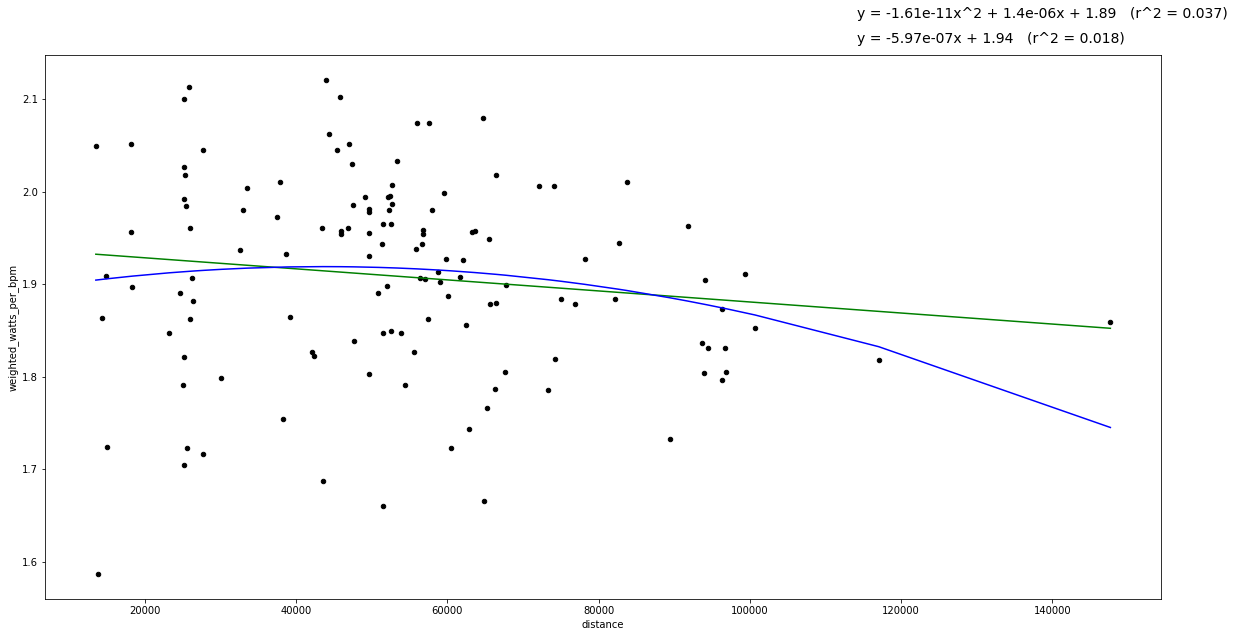

In [4]:
plot_best_fit('average_temp', 'weighted_average_watts', activity_df)
plot_best_fit('average_temp', 'suffer_score', activity_df)
plot_best_fit('average_watts', 'average_heartrate', activity_df)
plot_best_fit('weighted_average_watts', 'average_heartrate', activity_df)
plot_best_fit('average_temp', 'watts_per_bpm', activity_df)
plot_best_fit('average_temp', 'weighted_watts_per_bpm', activity_df)
plot_best_fit('average_temp', 'w_per_bpm_per_distance', activity_df)
plot_best_fit('distance', 'weighted_watts_per_bpm', activity_df)